In [1]:
import torch
from ignite import metrics

In [2]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from pathlib import Path
import pandas as pd

In [3]:
import time

def load_data(path: Path | str):
    '''
    load images and compute metrics against the original
    '''
    if isinstance(path, str): path = Path(path)

    original = cv2.imread(str(path / "original.png"), cv2.IMREAD_COLOR)
    original_tensor = torch.tensor(original, requires_grad=False).permute(2, 0, 1).unsqueeze(0).float().cuda()

    df = pd.DataFrame(columns=["algorithm", "quality", "bits", "mse", "psnr", "ssim"])

    for compressed_img_path in path.glob("*.png"):

        if compressed_img_path.stem == "original": continue

        last3 = compressed_img_path.stem.split("-")[-3:]
        algorithm = last3[0]
        quality = float(last3[1])
        bits = int(last3[2]) 

        compressed_img = cv2.imread(str(compressed_img_path), cv2.IMREAD_COLOR)
        compressed_img_tensor = torch.tensor(compressed_img, requires_grad=False).permute(2, 0, 1).unsqueeze(0).float().cuda()

        mse_metric = metrics.MeanSquaredError()
        mse_metric.update((original_tensor, compressed_img_tensor))
        mse = mse_metric.compute()

        psnr_metric = metrics.PSNR(255)
        psnr_metric.update((original_tensor, compressed_img_tensor))
        psnr = psnr_metric.compute()

        ssim_metric = metrics.SSIM(255)
        ssim_metric.update((original_tensor, compressed_img_tensor))
        ssim = ssim_metric.compute()
        
        del compressed_img_tensor
        torch.cuda.empty_cache()
        del mse_metric
        del psnr_metric
        del ssim_metric
    
        df.loc[len(df)] = [algorithm, quality, bits, mse, psnr, ssim]
    
    del original_tensor
    torch.cuda.empty_cache()

    df = df.sort_values(by=["algorithm", "quality"])
    return df


In [4]:
translations = {
    "ssim": "Structural similarity (SSIM)",
    "mse": "Mean squared error (MSE)",
    "psnr": "Peak signal-to-noise ratio (PSNR)",
    "multicut": "Multicut Encoding",
    "jpg": "JPEG",
    "algorithm": "Algorithm"
}


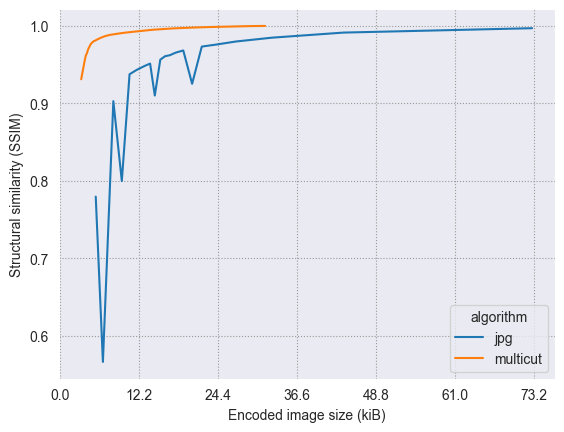

In [13]:
from matplotlib.ticker import FuncFormatter
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

def plot_time_series(df, metric):
    ax = sns.lineplot(
        df, 
        x="bits", 
        y=metric, 
        hue="algorithm", 
        legend="full"
    )
    ax.xaxis.set_major_formatter(FuncFormatter(lambda bits, _: f"{bits / 8192:.1f}"))
    ax.set_xlabel("Encoded image size (kiB)")
    ax.set_ylabel(translations[metric])


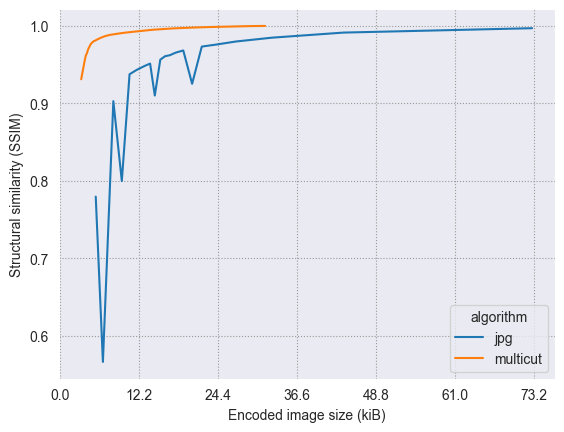

In [25]:
df = load_data(r"results/icon_512/actions-document-save")
plot_time_series(df, "ssim")
plt.savefig("actions-document-save-ssim-timeseries.png", dpi=600)

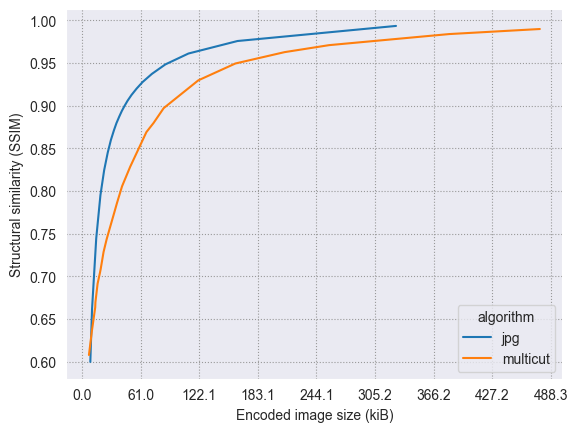

In [17]:
df = load_data(r"results/photo_kodak/kodim19")
plot_time_series(df, "ssim")
plt.savefig("kodim19-ssim-timeseries.png", dpi=600)

In [18]:
# def evaluate_category(category_dir: Path):
from math import log2

def score(df, jpeg_quality, metric, dir):
    '''
    Given a jpeg of a certain quality image, what is the minimum number of bits needed,
    for the multicut algorithm to match said quality (measured in one of the metrics)? 

    The score is then the ratio between both sizes (multicut_bits / jpeg_bits)
    '''
    
    jpeg_row = df[(df["algorithm"] == "jpg") & (df["quality"] == jpeg_quality)]
    jpeg_res = jpeg_row[metric].values[0]
    jpeg_bits = jpeg_row["bits"]

    try:
        if metric == "mse":
            least_multicut_bits = df[(df["algorithm"] == "multicut") & (df["mse"] <= jpeg_res)]["bits"].values.min()
        else:
            least_multicut_bits = df[(df["algorithm"] == "multicut") & (df[metric] >= jpeg_res)]["bits"].values.min()
    except: # if there is no image that fits, assume that the image would be encoded uncompressed
        img = cv2.imread(str(dir / "original.png"), cv2.IMREAD_COLOR)
        least_multicut_bits = 8 * img.shape[0] * img.shape[1] * img.shape[2]

    return log2((least_multicut_bits / jpeg_bits).iloc[0])




In [26]:
from tqdm import tqdm

df = pd.DataFrame(columns=["category", "imgname", "jpeg_quality", "mse_score", "ssim_score", "psnr_score"])

jpeg_quals = [95, 50, 10]

for category_dir in tqdm(list(Path("results").glob("*"))):
    dirs = list(category_dir.glob("*"))
    for dir in dirs:
        dir_df = load_data(dir)
        for q in jpeg_quals:
            df.loc[len(df)] = [category_dir.stem, dir.stem, q] + [score(dir_df, q, m, dir) for m in ["mse", "ssim", "psnr"]]

df

100%|██████████| 13/13 [03:09<00:00, 14.60s/it]


,category,imgname,jpeg_quality,mse_score,ssim_score,psnr_score
0,icon_512,actions-document-save,95,-1.612456,-1.958153,-1.612456
1,icon_512,actions-document-save,50,-1.356033,-2.029487,-1.356033
2,icon_512,actions-document-save,10,-1.048986,-1.337351,-1.048986
3,icon_512,actions-go-last,95,-2.138124,-3.473653,-2.138124
4,icon_512,actions-go-last,50,-1.916554,-2.633633,-1.916554
...,...,...,...,...,...,...
385,textures_plants,plant_58,50,0.635843,0.635843,0.635843
386,textures_plants,plant_58,10,0.635179,0.635179,0.635179
387,textures_plants,plant_60,95,0.202117,1.215288,0.202117
388,textures_plants,plant_60,50,0.693126,0.851355,0.693126


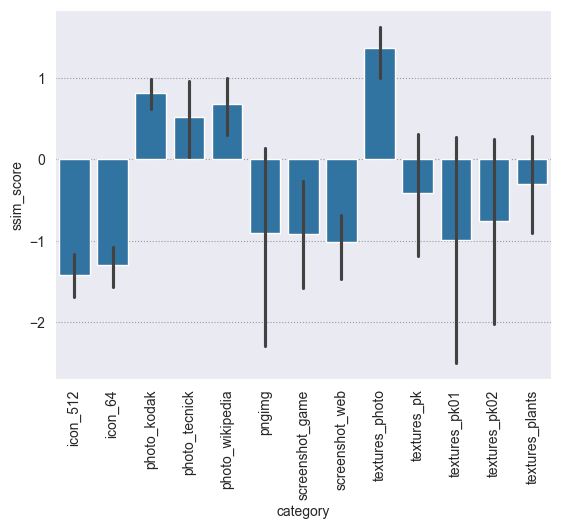

In [30]:
ax = sns.barplot(
    df[df["jpeg_quality"] == 10],
    x="category",
    y="ssim_score",
)

plt.xticks(rotation=90)
plt.savefig("score-by-category-quality-low.png", dpi=600, bbox_inches="tight")

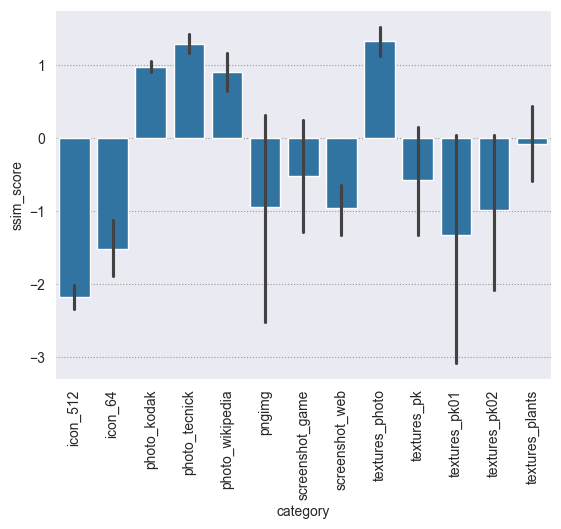

In [31]:
ax = sns.barplot(
    df[df["jpeg_quality"] == 50],
    x="category",
    y="ssim_score",
)

plt.xticks(rotation=90)
plt.savefig("score-by-category-quality-mid.png", dpi=600, bbox_inches="tight")

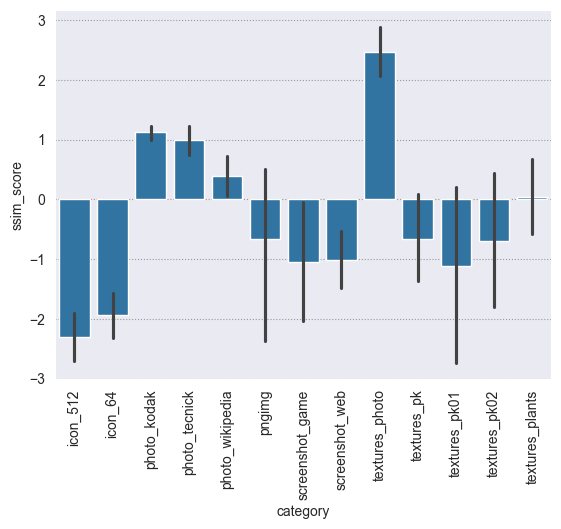

In [32]:
ax = sns.barplot(
    df[df["jpeg_quality"] == 95],
    x="category",
    y="ssim_score",
)

plt.xticks(rotation=90)
plt.savefig("score-by-category-quality-high.png", dpi=600, bbox_inches="tight")